# Model Selection and Optimization

## Objective
The objective of this notebook is to select the model that best suits our data through a comparison of their performance using cross validation. After selecting the top-performing model, we will further optimize its performance by tuning its hyperparameters. We will utilize Dask to accelerate our computations and MLflow to keep track of our experiments. By the end of this notebook, we will have chosen and exported the final model for deployment in a GUI.

## Table of Contents
1. Instantiate Dask Client
2. Defining Pipeline
2. Model Selection
3. Hyperparameter Tuning 
4. Final Selection

## Import Modules

In [24]:
import pandas as pd
import numpy as np
import joblib
import dask.dataframe as dd
from dask.distributed import Client, progress
from dask_ml.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
import pickle
import mlflow
from dask import config
import warnings
import time
warnings.filterwarnings("ignore")

## Utilize Dask
To scale our modelling process, we will use Dask, a parallel computing libary thats useful for modelling tasks that require processing large datasets.

Dask allows us to scale our computations up or down and makes it possible to work with large datasets on a single machine. It also provides parallel computing capabilities which can greatly reduce the time taken to train each model

In [26]:
# Instantiate Dask Client
client = Client()
client.amm.start()

In [27]:
config.set({'interface': 'lo'})

## Import as Dask Dataframe

In [99]:
# Read CSV file using Dask Pandas
ddf = dd.read_csv("TaxiDatasetAgg.csv")

- We imported the dataset exported from the Advanced_preprocessing file

In [29]:
ddf_comp = ddf.compute()

In [30]:
ddf_comp.shape

(19990, 91)

In [31]:
ddf_comp.head()

,accuracy_mean,accuracy_max,accuracy_min,accuracy_std,accuracy_25%,accuracy_75%,bearing_mean,bearing_max,bearing_min,bearing_std,...,turning_force_std,turning_force_25%,turning_force_75%,acceleration_mean,acceleration_max,acceleration_min,acceleration_std,acceleration_25%,acceleration_75%,label
0,9.855411,48.00,4.000,3.961431,8.0,12.00000,176.745606,359.97977,0.037464,129.792149,...,425243.970106,-545810.0650,-22569.36225,0.012712,0.137985,0.0,0.021438,0.004115,0.012772,0
1,3.922742,84.45,3.000,4.104310,3.0,4.00000,127.311267,337.00000,0.000000,89.155252,...,344555.457697,129148.6675,486373.53500,0.032536,1.839744,0.0,0.138877,0.000000,0.022038,1
2,3.818223,8.00,3.000,1.089036,3.0,3.95000,183.765060,330.00000,11.000000,113.946810,...,348493.922292,-103351.1050,335794.77000,0.056233,0.514143,0.0,0.092621,0.000000,0.093323,1
3,9.953348,11.00,4.069,0.481017,10.0,10.00000,149.783870,351.40985,2.271227,69.559743,...,303380.890713,-334010.3050,-63452.88125,0.036966,5.170000,0.0,0.258846,0.005585,0.020596,1
4,4.623058,12.00,3.000,1.365257,3.9,4.94575,194.469008,346.00000,0.000000,114.599572,...,359611.049924,83473.2410,454093.61000,0.064067,9.454126,0.0,0.521633,0.000000,0.015677,0


----------

## Split dataframe into Features and Target 
Split the dataframe into 80% Train and 20% Test Set

In [100]:
X = ddf.drop('label', axis=1)
y = ddf['label']

## Split using Dask Train Test Split 

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
print("X train shape: ",X_train.compute().shape)
print("y train shape: ",y_train.compute().shape)
print("X test shape: ",X_test.compute().shape)
print("y test shape: ",y_test.compute().shape)

X train shape:  (16022, 90)
y train shape:  (16022,)
X test shape:  (3968, 90)
y test shape:  (3968,)


## Remove Outliers
We will remove the outliers using a method called Local Outlier Factor as it was the best performing one

In [103]:
lso = LocalOutlierFactor(contamination=0.05)
ddf_output = lso.fit_predict(X_train.to_dask_array(lengths=True))

In [104]:
# Select rows which are not outliers
not_outliers = (ddf_output != -1)

In [105]:
X_train, y_train = X_train.to_dask_array(lengths=True)[not_outliers], y_train.to_dask_array(lengths=True)[not_outliers]

In [106]:
X_train

dask.array<getitem, shape=(15220, 90), dtype=float64, chunksize=(15220, 90), chunktype=numpy.ndarray>

In [107]:
y_train

dask.array<getitem, shape=(15220,), dtype=int64, chunksize=(15220,), chunktype=numpy.ndarray>

- 802 rows of the training set were remove which is around 5%. We are left with 15220 rows of data to train on.

## Defining Pipeline
Using a pipeline allows us to streamline the process of building, training and evaluating a mode. It helps to automate the steps involved and reduce the risk of human error. Lastly, Pipeline also makes it easier to scale and deploy modeul as the entire process is encapsulated within a single pipeline object

In [40]:
steps = [
    ("Oversampling", RandomOverSampler(random_state=11)),
    ("Standardisation", StandardScaler()),
    ('model')
]

## Evaluation Graphs
Here we defined a function to display several graphical representation and use them to measure our model's performance

#### ROC Curve & AUC Score

- The ROC curve is useful for evaluating the trade off between the true positive rate and false positive rate. A model with a high TPR and low FPR is considered a good model. ROC allows us to visualize this trade-off. 

- The AUC is a number that summarizes the performance of the mode over all possible classification thresholds and is useful when class distribution is imbalance. A high AUC score would indicate that the model is making more accurate predictions and a low AUC score would mean the model is not performing well.

#### Confusion Matrix
- The confusion matrix helps us to evaluate the model by showing us the number of correct and incorrect predictions made on the test set.

#### Learning Curve
- The learning curve helps us to identity whether a model is underfitting over overffiting

In [41]:
# # REMOVE
# X_train, y_train = RandomOverSampler(random_state=11).fit_resample(X_train, y_train) 
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [42]:
# Evaluate Classifier 
def evaluate_classifier(name, model):
    print(f'\n\n**********************{name}**********************')
#     with joblib.parallel_backend('dask'):
        
    model.fit(X_train, y_train)
#         steps[-1] = ("model", model)
#         model = Pipeline(steps=steps)
#         model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    auc = roc_auc_score(y_test, y_pred_proba)

    fig = plt.figure(figsize=(15,10))
    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])

    ax1.plot(fpr, tpr, label="AUC= " + str(auc))
    ax1.set_title(f'{name} - ROC Curve', fontsize=18)
    ax1.set_ylabel("True Positive Rate", fontsize=14)
    ax1.set_xlabel("False Positive Rate", fontsize=14)
    ax1.legend(loc=4, fontsize=14)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Dangerous", "Dangerous"])
    disp = disp.plot(ax=ax2, cmap='Blues')
    disp.ax_.set_title(name, fontsize=20)
    disp.ax_.set_xlabel('True Label', fontsize=14)
    disp.ax_.set_ylabel('Predicted Label', fontsize=14)

    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title('Learning Curve')
    plt.xlabel('Training Data Size')
    plt.ylabel('Model accuracy')
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()

## Metrics
We will use F1, accuracy, precision and recall scores to evaluate our models but mainly look at the F1 score as having a high precision without a high recall can lead to missing potentially driving instances while a high recall without high precision can result in false positive predictions. F1 allows us to balance both.

In [43]:
metric = ['f1', 'accuracy', 'precision', 'recall']

In [44]:
df_stats = {}    # Store model results

## Models

In [45]:
models = {
    "Decision Tree Classifier": DecisionTreeClassifier(),
    'Random Forest Classifier': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Gausian Naive Bayes': GaussianNB(),
}


## MLFlow - Track and Monitor Models
To streamline our Model Selection process, we will employ the use of MLFlow. MLflow is a centralized platform that allows us to track and compare multiple model runs along with their respective metrics. Making it easier to compare and select the best model. 

After each cross-validation, we will log each model's characteristics and their corresponding results

## Cross Validation on Models



**********************Decision Tree Classifier**********************


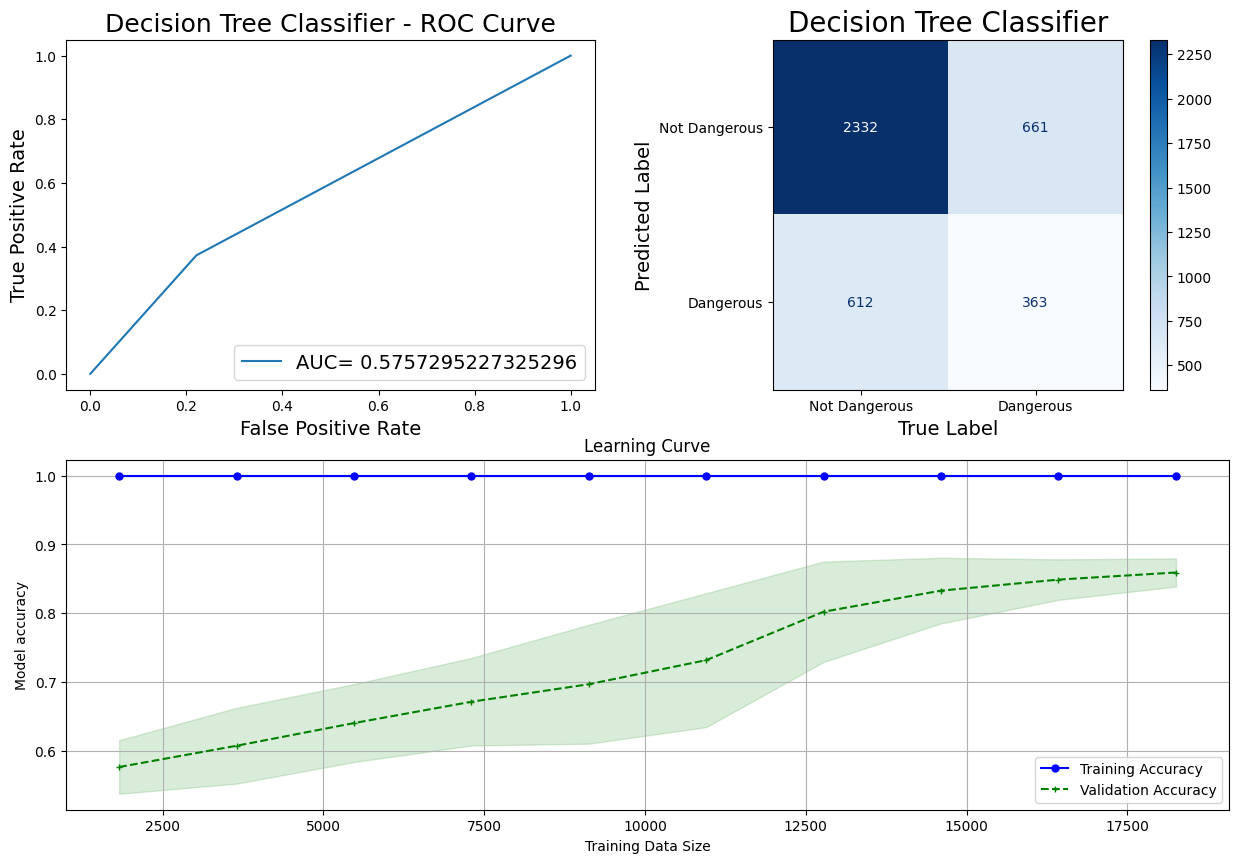



**********************Random Forest Classifier**********************


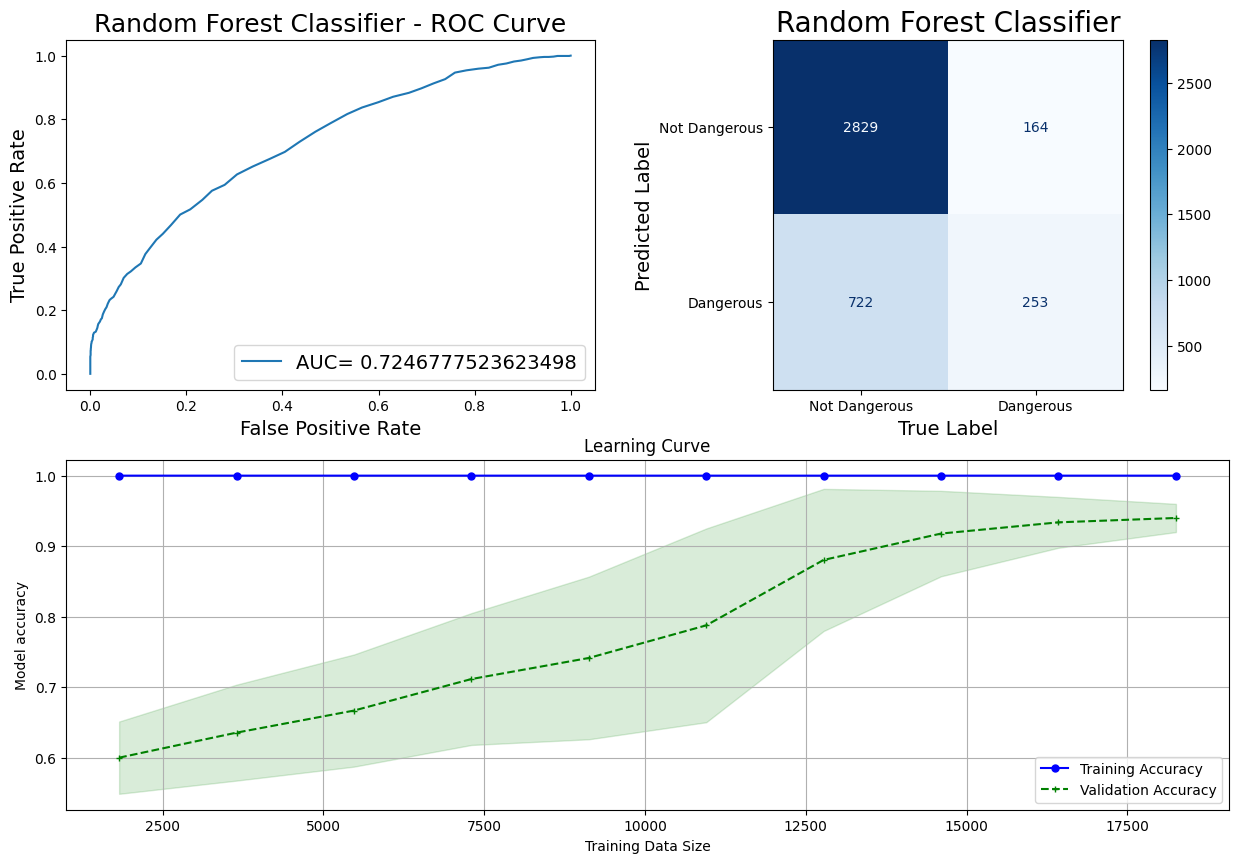



**********************Logistic Regression**********************


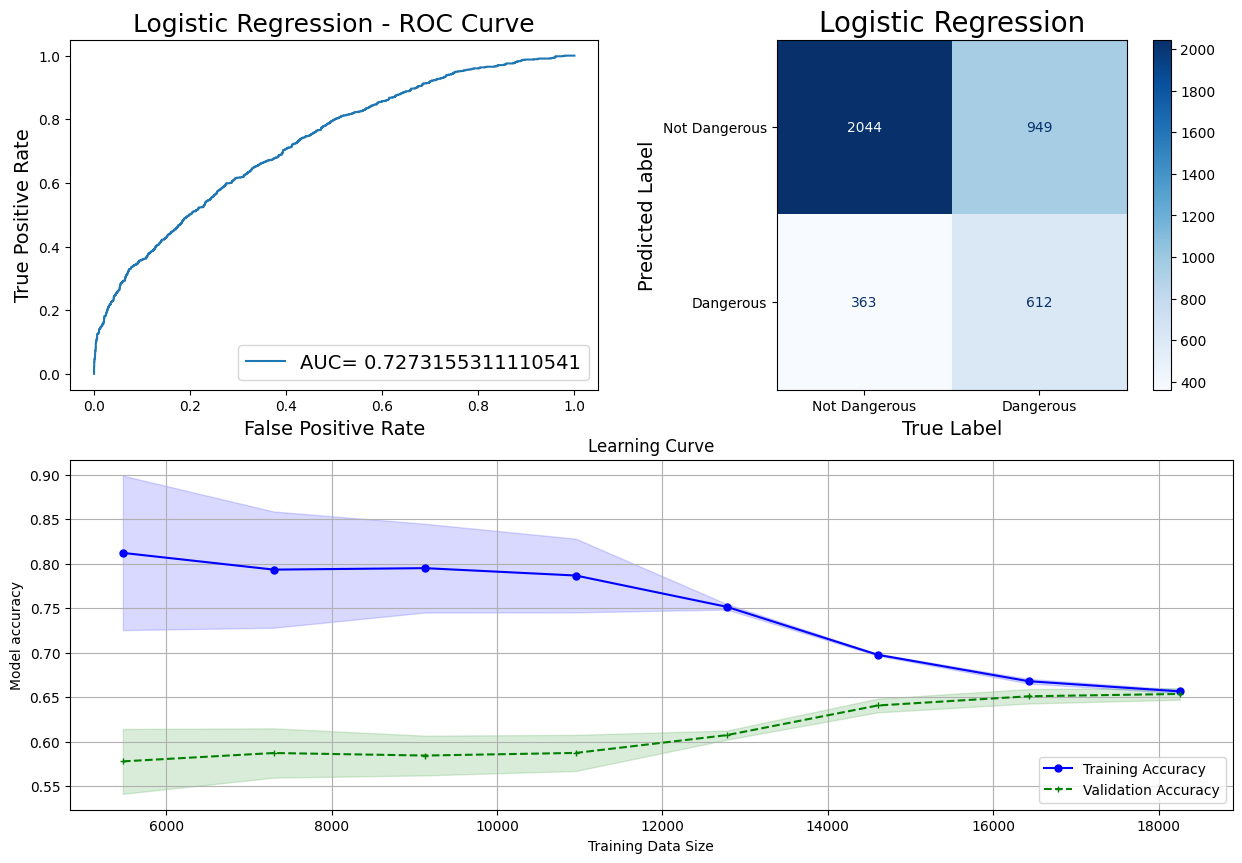



**********************KNN**********************


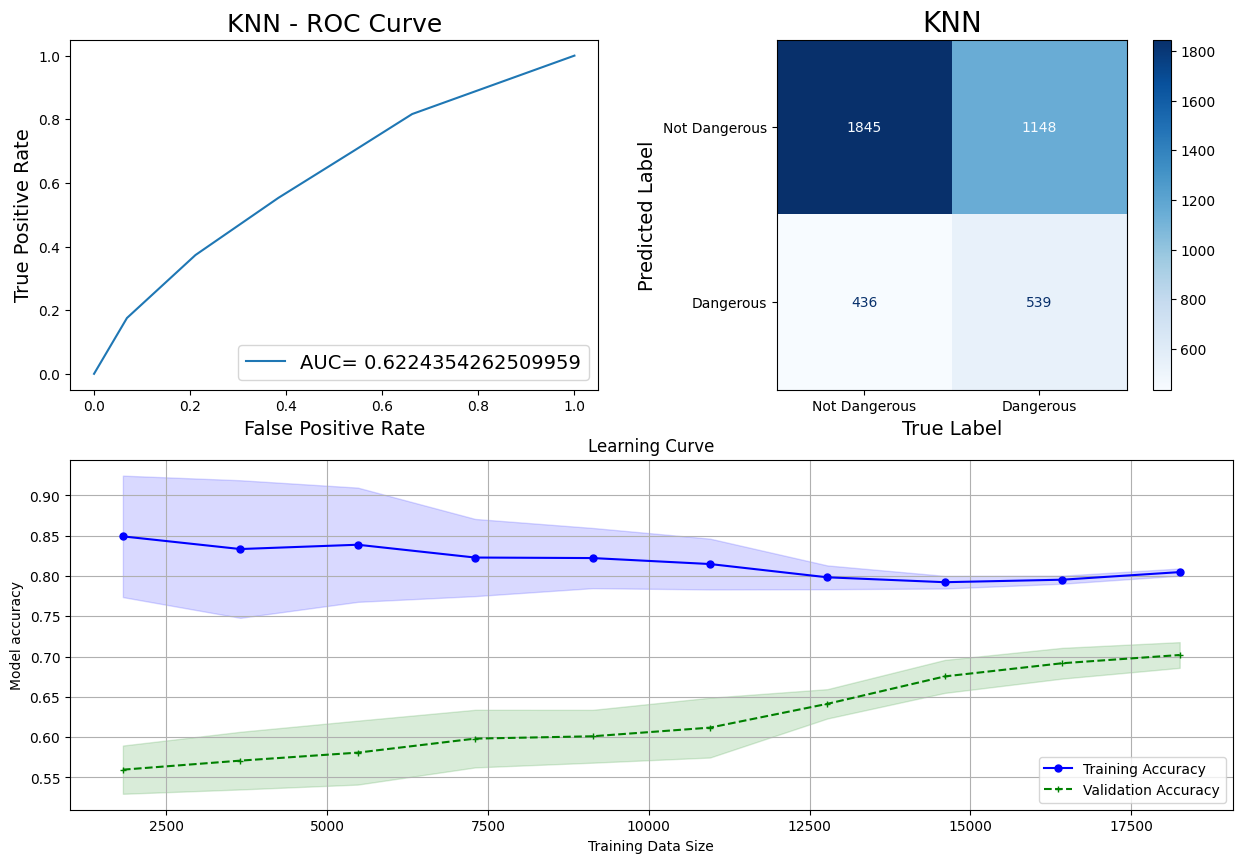



**********************Gausian Naive Bayes**********************


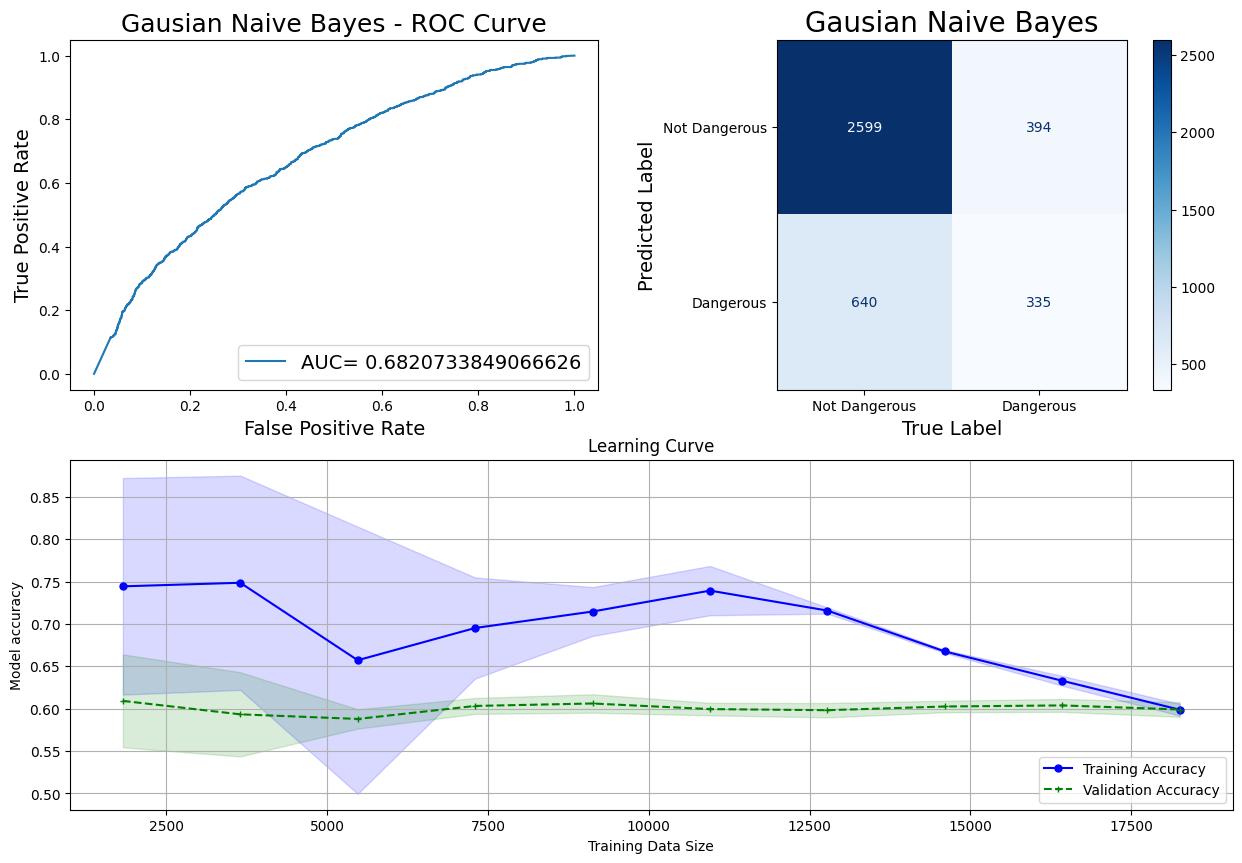

In [46]:
for name, model in models.items():
    with mlflow.start_run(run_name=name):
#         with joblib.parallel_backend('dask'):
#             steps[-1] = ("model", model)
#             clf_pipe = Pipeline(steps=steps)
            cv_results = cross_validate(model, X_train,
                                        y_train, return_train_score=True,
                                        cv=5, scoring=metric)

            cv_results_avg = {f'mean_{i}': np.mean(v) for i,v in cv_results.items()}   # Compute Mean of Metric CV results

            # Log Model Details into MLFlow
            mlflow.sklearn.log_model(
            model, 
            name, 
            serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_CLOUDPICKLE
            ) 

            # Log Metrics Details into MLFlow
            for i in cv_results_avg.keys():
                mlflow.log_metric(i, cv_results_avg[i])

            df_stats[name] = cv_results_avg   # Store Stats into Dictionary
            evaluate_classifier(name, model)    # Plot Graphs to Evaluate Model Performance

## Gradient Boosting Algorithms

In [47]:
models = {
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'Extreme Gradient Boosting': XGBClassifier(),
    'Light GBM': LGBMClassifier()
}



**********************Gradient Boosting Classifier**********************


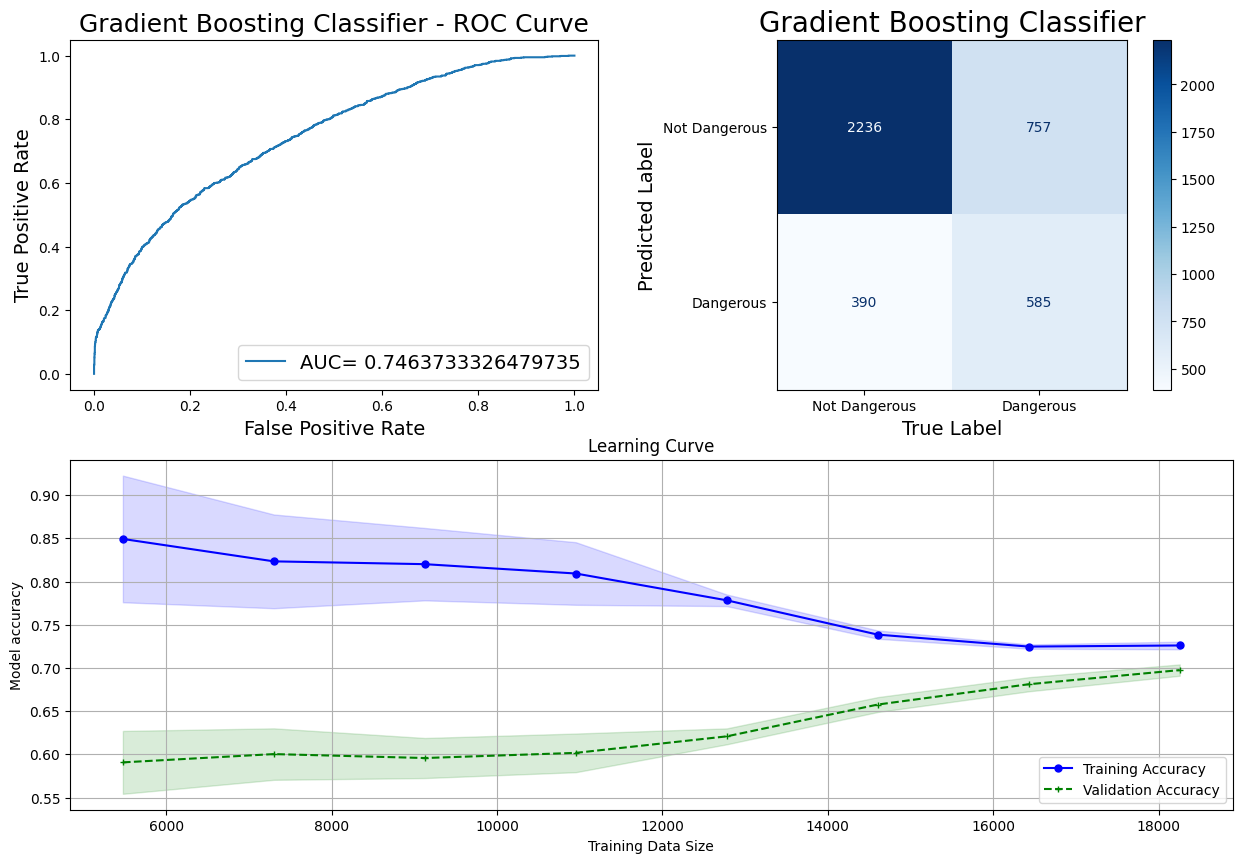



**********************Extreme Gradient Boosting**********************


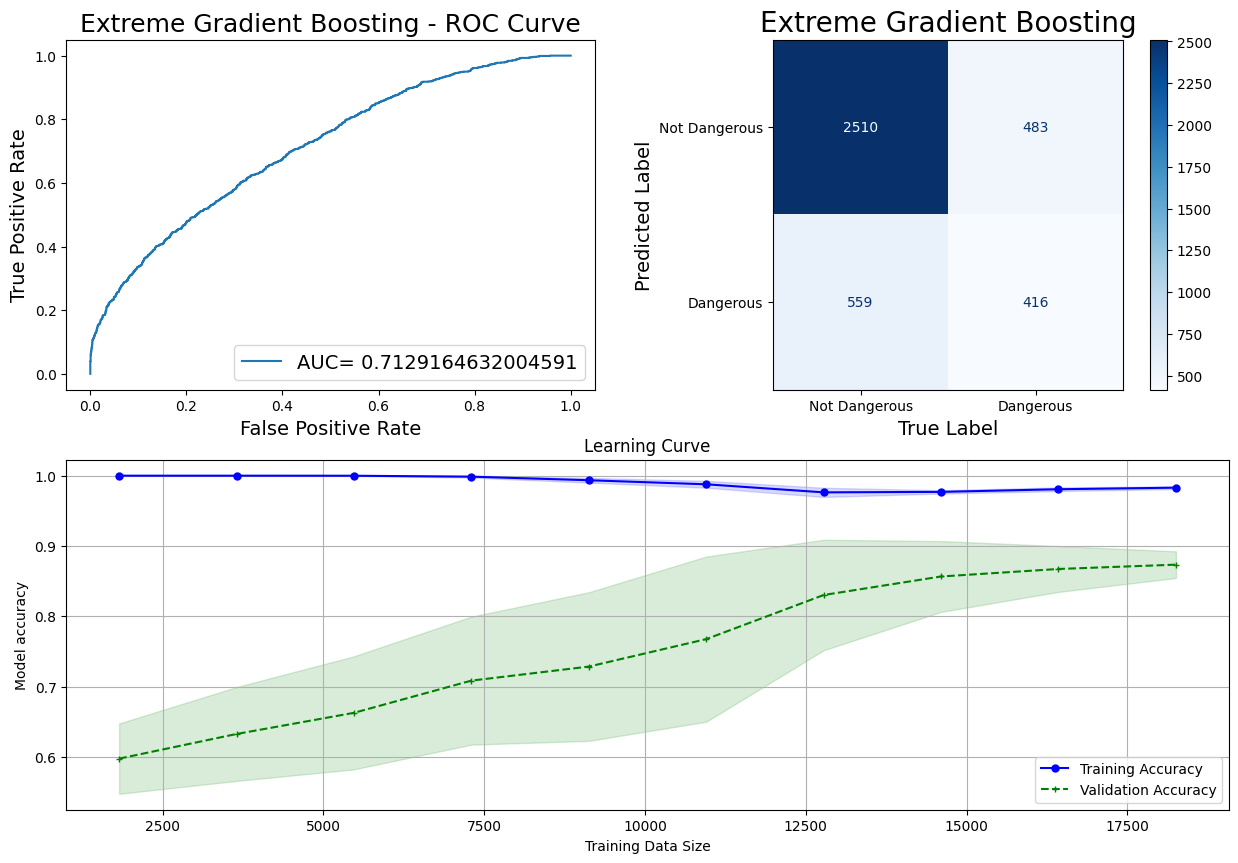



**********************Light GBM**********************


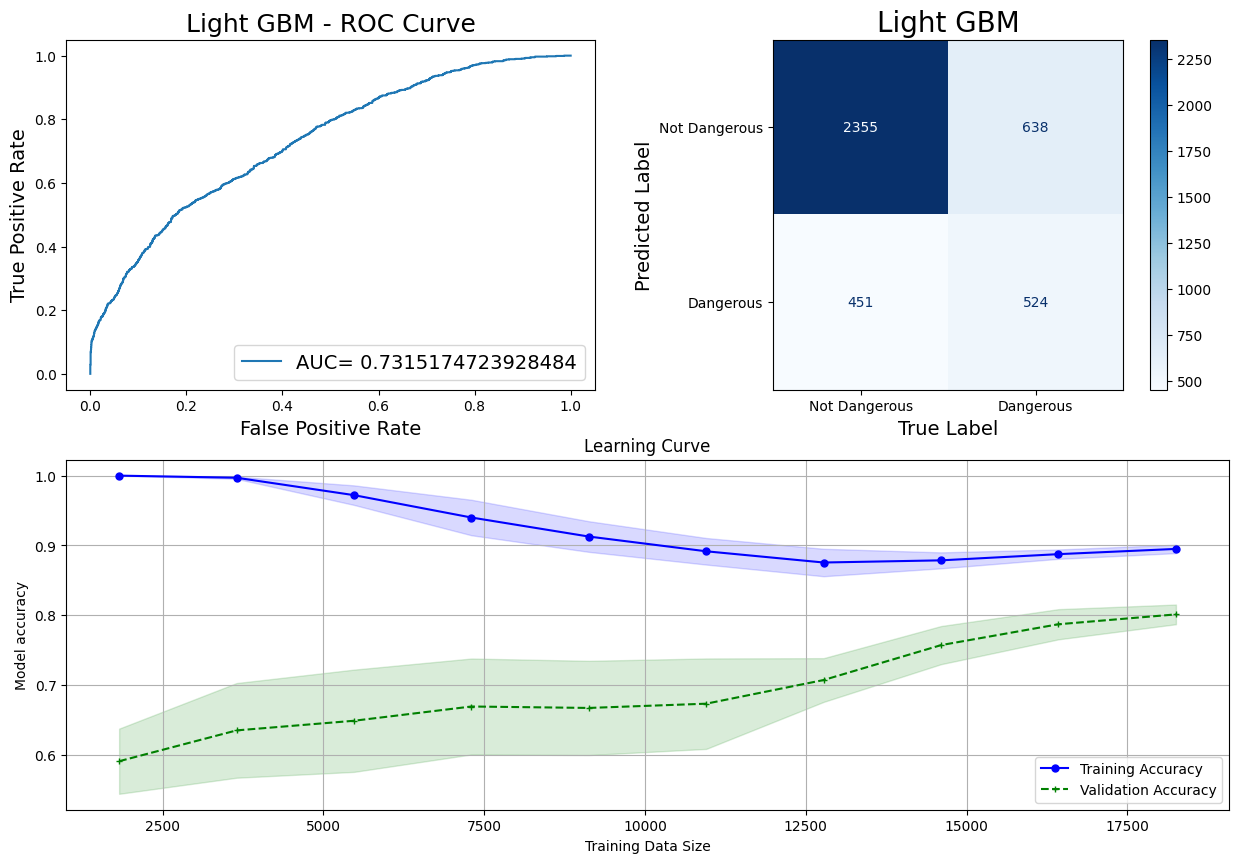

In [48]:
for name, model in models.items():
    with mlflow.start_run(run_name=name):
#         with joblib.parallel_backend('dask'):
#             steps[-1] = ("model", model)
#             clf_pipe = Pipeline(steps=steps)
            cv_results = cross_validate(model, X_train,
                                        y_train, return_train_score=True,
                                        cv=5, scoring=metric)

            cv_results_avg = {f'mean_{i}': np.mean(v) for i,v in cv_results.items()}   # Compute Mean of Metric CV results

            # Log Model Details into MLFlow
            mlflow.sklearn.log_model(
            model, 
            name, 
            serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_CLOUDPICKLE
            ) 

            # Log Metrics Details into MLFlow
            for i in cv_results_avg.keys():
                mlflow.log_metric(i, cv_results_avg[i])

            df_stats[name] = cv_results_avg   # Store Stats into Dictionary
            evaluate_classifier(name, model)    # Plot Graphs to Evaluate Model Performance

### View results in Dataframe

In [49]:
models_stats_df = pd.DataFrame(df_stats).T
display(models_stats_df)   

,mean_fit_time,mean_score_time,mean_test_f1,mean_train_f1,mean_test_accuracy,mean_train_accuracy,mean_test_precision,mean_train_precision,mean_test_recall,mean_train_recall
Decision Tree Classifier,2.544994,0.014202,0.870026,1.000000,0.855992,1.000000,0.791082,1.000000,0.967222,1.000000
Random Forest Classifier,15.351666,0.144609,0.941152,1.000000,0.940575,1.000000,0.923488,1.000000,0.960911,1.000000
Logistic Regression,0.740602,0.014799,0.647774,0.650220,0.653782,0.656664,0.659237,0.662654,0.636777,0.638246
KNN,0.010203,1.981996,0.727255,0.820001,0.701947,0.804858,0.669943,0.760897,0.795514,0.889101
Gausian Naive Bayes,0.050795,0.027002,0.445165,0.445063,0.599001,0.598716,0.721926,0.720867,0.322552,0.322771
Gradient Boosting Classifier,44.653957,0.017399,0.688310,0.717445,0.695372,0.724571,0.704455,0.736430,0.672976,0.699470
Extreme Gradient Boosting,7.562640,0.022401,0.877810,0.982798,0.871024,0.982821,0.831870,0.984117,0.929970,0.981484
Light GBM,1.213999,0.032601,0.806947,0.895696,0.801693,0.895028,0.785558,0.889934,0.829785,0.901547


## Observation
We will choose 2 best performing models by comparing the above metrics as well as their graphical representations

* <b>Decision Tree Classifier</b>: Model is serverly overfit and has a low F1 and precision score

* <b>Random Forest Classifier</b>: Model has a high F1 score as well as a high recall and decent precision score. Though the model does suffer from some overfit. We can consider using this model

* <b>Logistic Regression</b>: Model has a low F1 score, a decent precision and recall score

* <b>KNN</b>: Model has one of the highest F1 score compared to other models. It also obtained one of the highest precision and recall scores. We can consider using this model

* <b>Gausian Naive Bayes</b>: Has one of the lowest F1 score. Has a high precision score but a low recall score. We should not choose this model

* <b>Gradient Boosting Classifier</b>: Model has a low F1 score as well as a low precision and recall score. The model also seems to be slightly overfit

* <b>Extreme Gradient Boosting</b>: Model has a low F1 score and precision score but a decent recall score

* <b>Light GBM</b>: Model has a low F1 score and low  precision but a high recall score

## Models Chosen
After comparing between all 8 unique models, the team has decided to select both <b>DecisionTree Classifier</b> & <b>Random Forest Classifier</b> for hyperparameter tuning

---------------
# Optimization (Hyperparameter Tuning)
After choosing 2 best performing models, we wil now attempt to find the best set of hyperparameters for the models. We do this to achieve the best performance on the task we are trying to solve. Hyperparameter optimization can be done through methods such as gridsearchcv, randomsearchcv, etc. For this assignment we will use RandomSearchCV from dask_ml to save time and speed up the process. 

In [50]:
import dask_ml.model_selection as dcv

## Hyperparameter Tuning for Random Forest Classifier

In [109]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_leaf = [int(x) for x in np.linspace(10, 50, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
bootstrap = [True, False]
params = {'model__n_estimators': n_estimators,
          'model__max_features': max_features,
          'model__max_depth': max_depth,
          'model__min_samples_split': min_samples_split,
          'model__min_samples_leaf': min_samples_leaf,
          'model__bootstrap': bootstrap}


In [156]:
steps[-1] = ("model", RandomForestClassifier())
forest_pipe = Pipeline(steps=[
  ("Standardisation", StandardScaler()),
  ("model", RandomForestClassifier())
])
# steps = [
#     ("Oversampling", RandomOverSampler(random_state=11)),
#     ("Standardisation", StandardScaler()),
#     ('model')
# ]


In [157]:
tuned_forest = dcv.RandomizedSearchCV(forest_pipe, params, cv=5, scoring=metric, return_train_score=True, refit='f1')

In [158]:
tuned_forest.fit(pd.DataFrame(X_train.compute()), pd.DataFrame(y_train.compute()))

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('Standardisation',
                                              StandardScaler()),
                                             ('model',
                                              RandomForestClassifier())]),
                   param_distributions={'model__bootstrap': [True, False],
                                        'model__max_depth': [10, 20, 30, 40, 50,
                                                             60, 70, 80, 90,
                                                             100, 110, None],
                                        'model__max_features': ['auto', 'sqrt'],
                                        'model__min_samples_leaf': [10, 14, 18,
                                                                    23, 27, 32,
                                                                    36, 41, 45,
                                                                    50],
          

In [166]:
tuned_forest.best_estimator_

Pipeline(steps=[('Standardisation', StandardScaler()),
                ('model',
                 RandomForestClassifier(bootstrap=False, max_depth=100,
                                        max_features='sqrt',
                                        min_samples_leaf=18,
                                        min_samples_split=5,
                                        n_estimators=1200))])

## Evaluate Tuned RandomForestClassifier

In [189]:
forest_stat = {}

In [190]:
models = {
    "Tuned RandomForestClassifier": RandomForestClassifier(bootstrap=False, max_depth=100,
                                                           max_features='sqrt',
                                                           min_samples_leaf=18,
                                                           min_samples_split=5,
                                                           n_estimators=1200)
}




**********************Tuned RandomForestClassifier**********************


2023-02-10 12:18:23,118 - distributed.scheduler - ERROR - Couldn't gather keys {"('getitem-ad5694fd17100874122c906eca154d50', 0)": []} state: ['waiting'] workers: []
NoneType: None
2023-02-10 12:18:23,119 - distributed.scheduler - ERROR - Shut down workers that don't have promised key: [], ('getitem-ad5694fd17100874122c906eca154d50', 0)
NoneType: None


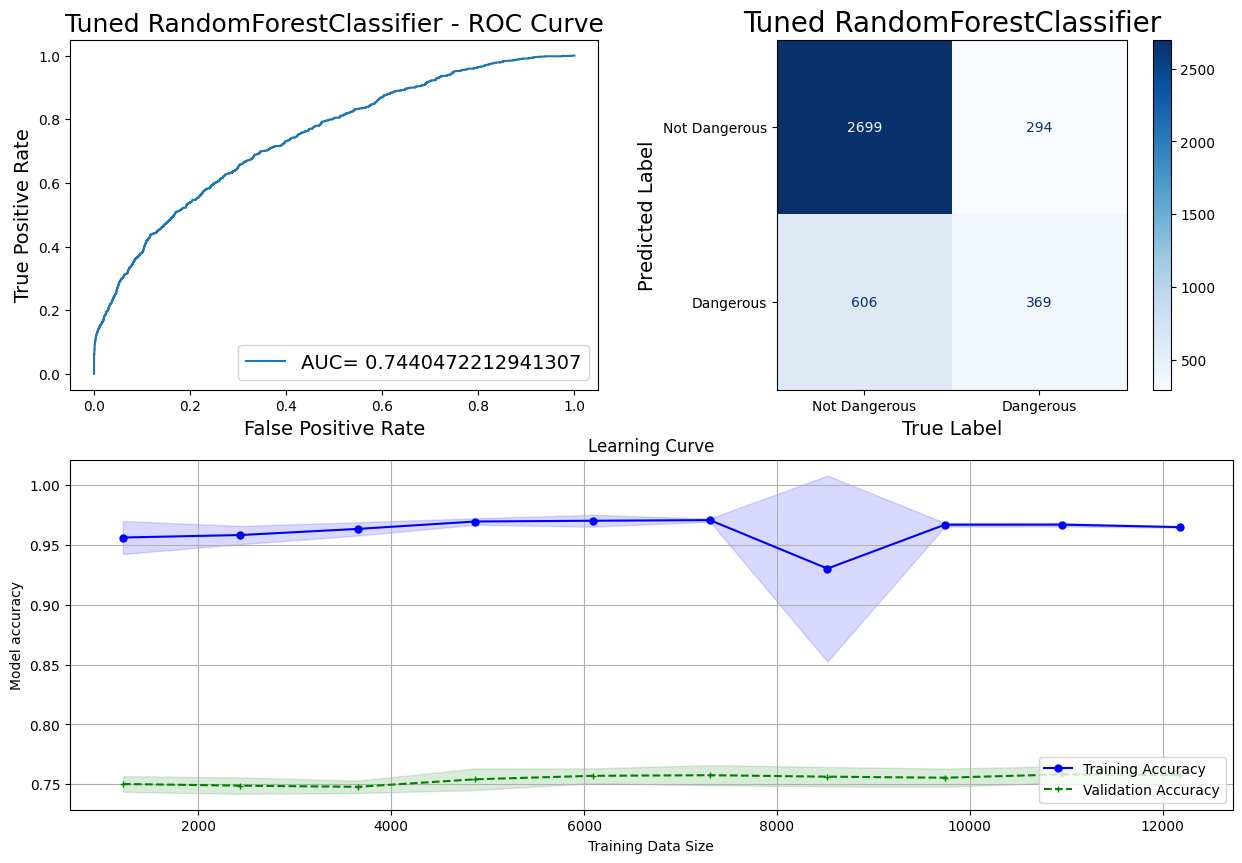

In [195]:
for name, model in models.items():
    with mlflow.start_run(run_name=name):
        with joblib.parallel_backend('dask'):
            steps[-1] = ("model", model)
            clf_pipe = Pipeline(steps=steps)
            cv_results = cross_validate(clf_pipe, X_train,
                                        y_train, return_train_score=True,
                                        cv=5, scoring=metric, n_jobs=-1)

            cv_results_avg = {f'mean_{i}': np.mean(v) for i,v in cv_results.items()}   # Compute Mean of Metric CV results

            # Log Model Details into MLFlow
            mlflow.sklearn.log_model(
            model, 
            name, 
            serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_CLOUDPICKLE
            ) 

            # Log Metrics Details into MLFlow
            for i in cv_results_avg.keys():
                mlflow.log_metric(i, cv_results_avg[i])

            forest_stat[name] = cv_results_avg   # Store Stats into Dictionary
            evaluate_classifier(name, clf_pipe)    # Plot Graphs to Evaluate Model Performance

In [196]:
forest_stat_df = pd.DataFrame(forest_stat).T

In [197]:
display(forest_stat_df)

,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_f1,mean_test_precision,mean_test_recall,mean_train_accuracy,mean_train_f1,mean_train_precision,mean_train_recall
Tuned RandomForestClassifier,230.749321,18.822898,0.757622,0.432299,0.522706,0.368663,0.964882,0.930344,0.924296,0.936499


### Evaluation
The tuned version of the model shows improvement over the untuned version in terms of F1 score and precision. Although the time taken to train the tuned model is longer, it ultimately delivered better results, achieving a higher F1 and precision score, however its recall score decreased slightly. Overall, after hyperparameter tuning, the model did improve.

--------

## Hyperparameter Tuning for DecisionTree Classifier

In [159]:
params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
min_samples_leaf = [int(x) for x in np.linspace(10, 50, num=10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
bootstrap = [True, False]
params = {
          'model__max_features': max_features,
          'model__max_depth': max_depth,
          'model__min_samples_split': min_samples_split,
          'model__min_samples_leaf': min_samples_leaf
          }


In [160]:
steps[-1] = ("model", DecisionTreeClassifier())
dc_pipe = Pipeline(steps=steps)

In [161]:
tuned_dc = dcv.RandomizedSearchCV(dc_pipe, params, cv=5, scoring=metric, return_train_score=True, refit='f1')

In [162]:
tuned_dc = tuned_dc.fit(X_train, y_train)

In [172]:
tuned_dc.best_estimator_


Pipeline(steps=[('Standardisation', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(max_depth=90, max_features='auto',
                                        min_samples_leaf=14,
                                        min_samples_split=10))])

In [173]:
models = {
    "Tuned DC": DecisionTreeClassifier(max_depth=90, max_features='auto',
                                        min_samples_leaf=14,
                                        min_samples_split=10)
}

In [182]:
dc_stat = {}



**********************Tuned DC**********************


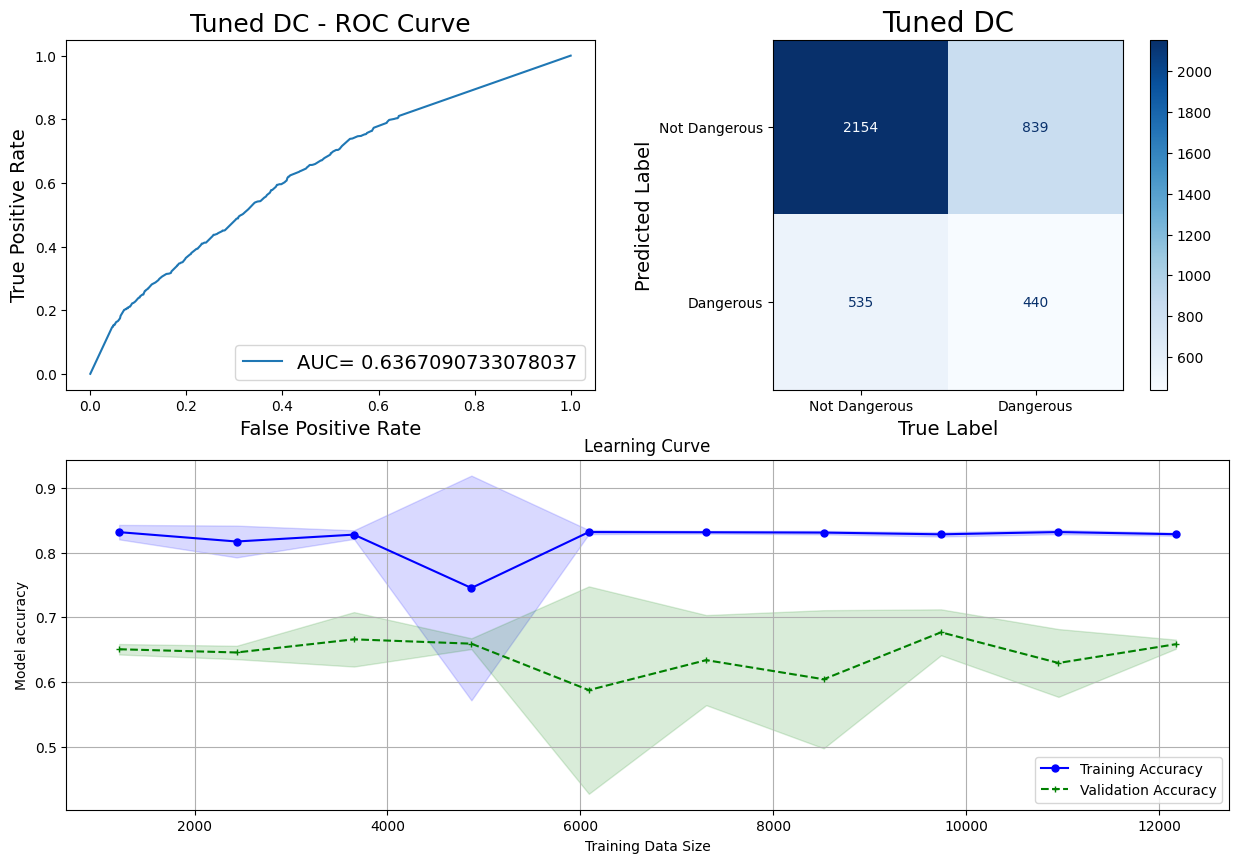

In [183]:
for name, model in models.items():
    with mlflow.start_run(run_name=name):
        with joblib.parallel_backend('dask'):
            steps[-1] = ("model", model)
            clf_pipe = Pipeline(steps=steps)
            cv_results = cross_validate(clf_pipe, X_train,
                                        y_train, return_train_score=True,
                                        cv=5, scoring=metric, n_jobs=-1)

            cv_results_avg = {f'mean_{i}': np.mean(v) for i,v in cv_results.items()}   # Compute Mean of Metric CV results

            # Log Model Details into MLFlow
            mlflow.sklearn.log_model(
            model, 
            name, 
            serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_CLOUDPICKLE
            ) 

            # Log Metrics Details into MLFlow
            for i in cv_results_avg.keys():
                mlflow.log_metric(i, cv_results_avg[i])

            dc_stat[name] = cv_results_avg   # Store Stats into Dictionary
            evaluate_classifier(name, clf_pipe)    # Plot Graphs to Evaluate Model Performance

In [184]:
dc_stat_df = pd.DataFrame(dc_stat).T

In [185]:
display(dc_stat_df)

,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_f1,mean_test_precision,mean_test_recall,mean_train_accuracy,mean_train_f1,mean_train_precision,mean_train_recall
Tuned DC,5.762597,17.980265,0.650263,0.376804,0.340155,0.422452,0.826462,0.695039,0.620605,0.789819


### Evaluation
The tuned model performed better than the untuned version of the model. This can be shown in its F1 score in which it increased by 0.06 which is a huge improvement. Though its precision score decreased slightly, the recall score excels by alot compared to the untuned model. Overall hyperparameter tuning has help improve the model's performance

# Final Model Selection
After evaluating both tuned models and weighing the pros and cons between the 2 models. The team decided to go with KNN model as it had performed better in several key areas

## Export Model
We exported the tuned KNN model using pickle and move on to GUI Development where we will deploy the model

In [198]:
# Train final model on X and y
tuned_dc_model = tuned_dc.best_estimator_.fit(X,y)

In [199]:
# Export
pickle.dump(tuned_dc_model, open('tuned_dc.pkl', 'wb'))

In [200]:
# Train final model on X and y
tuned_forest_model = tuned_forest.best_estimator_.fit(X, y)


In [201]:
# Export
pickle.dump(tuned_forest_model, open('tuned_forest.pkl', 'wb'))

In [206]:
dc_stat_df


,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_f1,mean_test_precision,mean_test_recall,mean_train_accuracy,mean_train_f1,mean_train_precision,mean_train_recall
Tuned DC,5.762597,17.980265,0.650263,0.376804,0.340155,0.422452,0.826462,0.695039,0.620605,0.789819
